In [2]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def algo_simulator(budget:int,workers_power:int,quality:float,noise:float):
    runs=[]
    for i in range((2**workers_power)):
        runs.append([1])
    prev_workers=2**workers_power
    for i in range(1,budget):
        multiplier=budget/(i+1)
        current_workers=2**min(np.floor(np.log2(multiplier)),workers_power)
        runs= sorted(runs, key=lambda x: x[-1])
        if current_workers!=prev_workers:
            for worker in range(int(current_workers)):
                new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
                runs[worker].append(min([runs[worker][-1],new_point]))
        prev_workers=current_workers
    return runs

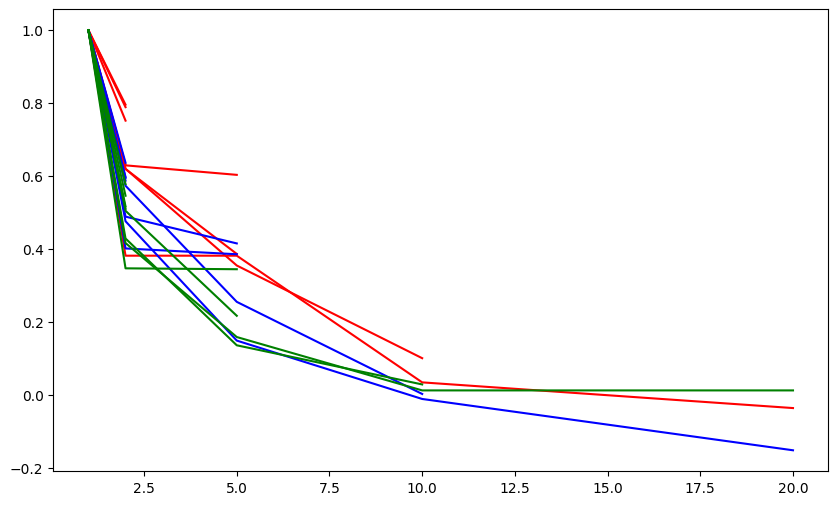

In [15]:
max_budget=20
number_of_workers_power=4
quality=[0.5,0.6,0.8]
colors=["red","blue","green"]
noise=0.1

runs=[]
y_data=[]
algo_numbers=[]
for algo_number in range(len(quality)):
    run=algo_simulator(budget=max_budget,workers_power=number_of_workers_power,quality=quality[algo_number],noise=noise)
    runs+=run
    algo_numbers+=list(np.ones(shape=len(run),dtype=int)*algo_number)

for run in runs:
    y_data.append([])
    for i in range(0,len(run)):
        y_data[-1].append(int((2**i/2**number_of_workers_power)*max_budget))



_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(runs):
    axis.errorbar(
        y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

In [16]:
saved_runs=runs
saved_y_data=y_data
saved_algo_numbers=algo_numbers


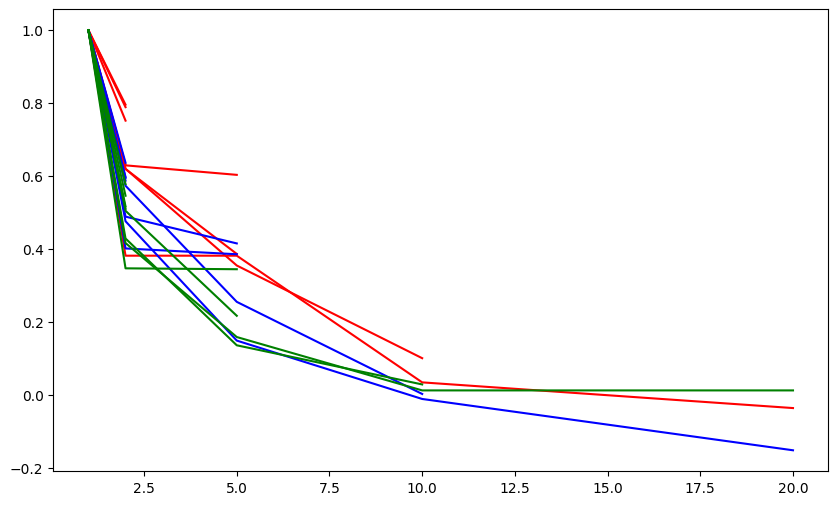

In [17]:
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)


_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(saved_runs):
    axis.errorbar(
        saved_y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

df=pd.DataFrame(columns=["score","budget","algo","rng"])
for run_number,run in enumerate(saved_runs):
    for data_number,datapoint in enumerate(run):
        df.loc[len(df)] =[datapoint,saved_y_data[run_number][data_number],str(saved_algo_numbers[run_number]),str(random.randint(0,2))]


#conduct_analysis(df,"score","algo","rng")

In [33]:
from pymer4 import Lmer

metric="score"
system_id="algo"
input_id="rng"
random_effect="budget"

no_random_effect_model = Lmer(
    formula=f"{metric}~{system_id}+(1|{input_id})", data=df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
no_random_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(no_random_effect_model.summary())
print("Ranef:")
print(no_random_effect_model.ranef)
print()



fixed_effect_model = Lmer(
    formula=f"{metric}~{system_id}+(1|{random_effect})+(1|{input_id})", data=df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
fixed_effect_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)
print(fixed_effect_model.summary())
print("Ranef:")
print(fixed_effect_model.ranef)
print()


post_hoc_results2 = no_random_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results2)


post_hoc_results3 = fixed_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results3)






boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: score~algo+(1|rng)

Family: gaussian	 Inference: parametric

Number of observations: 93	 Groups: {'rng': 3.0}

Log-likelihood: -34.661 	 AIC: 79.322

Random effects:

                 Name    Var    Std
rng       (Intercept)  0.000  0.000
Residual               0.123  0.351

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)     0.743   0.620    0.867  0.063  93.0  11.783  0.000  ***
algo1          -0.053  -0.228    0.122  0.089  93.0  -0.594  0.554     
algo2          -0.074  -0.249    0.101  0.089  93.0  -0.826  0.411     
Ranef:
   X.Intercept.
0           0.0
1           0.0
2           0.0

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: score~algo+(1|budget)+(1|rng)

Family: gaussian	 Inference: parametric

N